In [11]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib as plt
import util1 as u

In [9]:
# 將圖片顯示出來, 每行 10 張圖, 最多 240 張圖
# 參數依序為：圖片資料集,標籤資料集,開始顯示的索引,顯示的圖片數量,預測的答案資料集
# 若 num 為 0 則顯示由 start 開始的全部圖片
def showImgs(imgs, labs, start=0, num=0, predicts=[], by0123=True):
    max_num = len(imgs)-start
    if max_num > 240: max_num = 240  # 最多只顯示 240 張圖
    if num <= 0 or num > max_num: num = max_num
    plt.gcf().set_size_inches(16, 52 if len(predicts) else 40)
    idx_list = get_idxs(imgs, labs, start, num, by0123)
    for i in range(num):
        ax = plt.subplot(24, 10, 1+i)
        idx = idx_list[i]
        ax.imshow(imgs[idx], cmap='gray_r',   #反白顯示 (白底黑字)
                  norm=plt.Normalize(0.0, 255.0))  #指定灰階的範圍
        if len(predicts):
            title = 'label = ' + str(labs[idx])
            if labs[idx] == predicts[idx]:
                title += '\npredi = ' + str(predicts[idx])
            else:
                title += '\npre● = ' + str(predicts[idx])
            ax.set_title(title, fontsize=13)
        ax.set_xticks([]); ax.set_yticks([]) # X, Y 軸不顯示刻度
    plt.show()

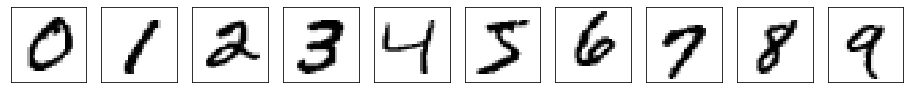

In [17]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28


adj_size = 0   # 指定要將數字調整為多少像素, 設為 0 表示不調整
fns = ''        # 檔名附加訊息

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

u.showImgs(x_train, y_train, 0, 10)


In [18]:
if adj_size > 0:
    fns = '_S' + str(adj_size)
    print(f'調整 MNIST 圖片的數字大小改為 {adj_size} 像素, 並置中')
    import lab_mnist_util as u
    for i in range(len(x_train)):
        if i % 1000 == 0: print(i,end=',')
        x_train[i] = u.img_best(x_train[i], size=adj_size, vdif=1, hdif=1)
    for i in range(len(x_test)):
        if i % 1000 == 0: print(i,end=',')
        x_test[i] = u.img_best(x_test[i], size=adj_size, vdif=1, hdif=1)
    u.showImgs(x_train, y_train, 0, 10)
    print(f'\n調整完成, 開始預處理及訓練模型...')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


In [19]:
# 預設理
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  #0.25神經元暫停訓練不影響學習參數,但可避免overfitting
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))   #0.5神經元暫停訓練不影響學習參數,但可避免overfitting
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary() #Total params: 1,199,882

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [22]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))  #先不另外切validation出來直接用testing set

score = model.evaluate(x_test, y_test, verbose=0)
print('對測試資料集的準確率：', score[1])
#對測試資料集的準確率： 0.9913

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.2349 - accuracy: 0.9291 - val_loss: 0.0524 - val_accuracy: 0.9834
Epoch 2/12
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.0842 - accuracy: 0.9747 - val_loss: 0.0367 - val_accuracy: 0.9883
Epoch 3/12
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.0643 - accuracy: 0.9804 - val_loss: 0.0343 - val_accuracy: 0.9888
Epoch 4/12
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.0520 - accuracy: 0.9844 - val_loss: 0.0305 - val_accuracy: 0.9909
Epoch 5/12
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.0427 - accuracy: 0.9867 - val_loss: 0.0315 - val_accuracy: 0.9888
Epoch 6/12
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.0399 - accuracy: 0.9875 - val_loss: 0.0335 - val_accuracy: 0.9902
Epoch 7/12
60000/60000 [==============================] 

In [26]:
#程 將模型存檔
model.save('模型_CNN' + fns + '_new.h5')   #← 將模型以指定的檔名存檔
